# Sequential Memory: RNN, LSTM, GRU Deep Dive

**Mobile Keyboard Problem**: Autocomplete forgets context after a few words. When typing "The restaurant was great but the service was...", it forgets "restaurant" and suggests random words.

**Solution**: Build sequential models with memory.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

# Import our utility functions and models
from utils import *

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")

Using device: cpu


## Data: WikiText-2 Character Sequences

In [2]:
# Load and prepare WikiText-2 dataset
dataset = load_dataset('wikitext', 'wikitext-2-v1')
text = ' '.join(dataset['train']['text'][:120])
text = ''.join(c for c in text if c.isprintable() and c != '\t')
text = text[:60000]  # 60k characters

# Prepare all data splits and mappings
data = prepare_data(text, short_seq_len=10, long_seq_len=50)

print(f"Text: {len(text):,} characters")
print(f"Vocabulary: {data['vocab_size']} unique characters")
print(f"Preview: {repr(text[:120])}")
print(f"\nData splits prepared:")
print(f"  Short sequences (10 chars): {data['short_train'][0].shape[0]:,} train, {data['short_test'][0].shape[0]:,} test")
print(f"  Long sequences (50 chars):  {data['long_train'][0].shape[0]:,} train, {data['long_test'][0].shape[0]:,} test")

Text: 38,495 characters
Vocabulary: 93 unique characters
Preview: '  = Valkyria Chronicles III =    Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the'

Data splits prepared:
  Short sequences (10 chars): 30,788 train, 7,697 test
  Long sequences (50 chars):  30,756 train, 7,689 test


In [3]:
# Extract data for easier access
vocab_size = data['vocab_size']
char2idx = data['char2idx']
idx2char = data['idx2char']

short_X_train, short_y_train = data['short_train']
short_X_test, short_y_test = data['short_test']
long_X_train, long_y_train = data['long_train']
long_X_test, long_y_test = data['long_test']

print(f"Example input: {[idx2char[i] for i in short_X_train[0][:5].tolist()]}")
print(f"Example target: '{idx2char[short_y_train[0].item()]}'")

Example input: [' ', ' ', '=', ' ', 'V']
Example target: 'i'


## Feedforward vs Recurrent Architecture

In [4]:
# Create all model instances for comparison
models = create_all_models(vocab_size)

# Extract individual models for easier access
mlp_model = models['mlp_short']
rnn_model = models['rnn']

# Analyze parameter fairness
analyze_parameter_fairness(models)

MLP_SHORT  params: 29,565
MLP_LONG   params: 111,485
RNN        params: 112,285
LSTM       params: 359,581
GRU        params: 277,149

PARAMETER ANALYSIS
mlp_short   : 29,565 parameters
mlp_long    : 111,485 parameters
rnn         : 112,285 parameters
lstm        : 359,581 parameters
gru         : 277,149 parameters

✅ Parameter counts are reasonably balanced


## Training & Evaluation
*Training and evaluation functions are imported from utils.py*

In [5]:
# Train models on short sequences for initial comparison
print("🚀 Training models on SHORT sequences (10 characters)...")

print("\nTraining MLP...")
mlp_losses = train_model(mlp_model, short_X_train[:10000], short_y_train[:10000], is_sequential=False)

print("\nTraining RNN...")
rnn_short_losses = train_model(rnn_model, short_X_train[:10000], short_y_train[:10000], is_sequential=True)

print("\n" + "="*50)
print("📊 SHORT SEQUENCE RESULTS (Test Set)")
print("="*50)

# Evaluate on test set
mlp_test_loss, mlp_test_acc = evaluate_model(mlp_model, short_X_test[:2000], short_y_test[:2000], is_sequential=False)
rnn_test_loss, rnn_test_acc = evaluate_model(rnn_model, short_X_test[:2000], short_y_test[:2000], is_sequential=True)

short_results = {
    'MLP': (mlp_test_loss, mlp_test_acc),
    'RNN': (rnn_test_loss, rnn_test_acc)
}

print_performance_summary(short_results)

🚀 Training models on SHORT sequences (10 characters)...

Training MLP...
Epoch  2: Loss = 2.5965
Epoch  4: Loss = 2.3146
Epoch  6: Loss = 2.1645
Epoch  2: Loss = 2.5965
Epoch  4: Loss = 2.3146
Epoch  6: Loss = 2.1645
Epoch  8: Loss = 2.0614

Training RNN...
Epoch  8: Loss = 2.0614

Training RNN...
Epoch  2: Loss = 2.1137
Epoch  2: Loss = 2.1137
Epoch  4: Loss = 1.6915
Epoch  4: Loss = 1.6915
Epoch  6: Loss = 1.4485
Epoch  6: Loss = 1.4485
Epoch  8: Loss = 1.2896

📊 SHORT SEQUENCE RESULTS (Test Set)

PERFORMANCE SUMMARY
MLP         : Loss = 2.3669, Accuracy = 0.342
RNN         : Loss = 2.5473, Accuracy = 0.392
Epoch  8: Loss = 1.2896

📊 SHORT SEQUENCE RESULTS (Test Set)

PERFORMANCE SUMMARY
MLP         : Loss = 2.3669, Accuracy = 0.342
RNN         : Loss = 2.5473, Accuracy = 0.392


## Experiment 1: Short Sequences
*Short sequences show where MLP can still compete with RNNs*

## Experiment 2: Long Sequences - Where RNNs Shine
*Extended sequences reveal the power of sequential processing*

🚀 Training models on LONG sequences (50 characters)...

Training RNN (Extended: 15 epochs)...
Epoch  2: Loss = 1.2012
Epoch  2: Loss = 1.2012
Epoch  4: Loss = 1.0325
Epoch  4: Loss = 1.0325
Epoch  6: Loss = 0.9384
Epoch  6: Loss = 0.9384
Epoch  8: Loss = 0.8780
Epoch  8: Loss = 0.8780
Epoch 10: Loss = 0.8130
Epoch 10: Loss = 0.8130
Epoch 12: Loss = 0.7740
Epoch 12: Loss = 0.7740
Epoch 14: Loss = 0.7434
Epoch 14: Loss = 0.7434

Training MLP...
Epoch  2: Loss = 2.7220

Training MLP...
Epoch  2: Loss = 2.7220
Epoch  4: Loss = 2.2744
Epoch  6: Loss = 1.9771
Epoch  4: Loss = 2.2744
Epoch  6: Loss = 1.9771
Epoch  8: Loss = 1.7342

📊 LONG SEQUENCE RESULTS (50 chars) - Test Set

PERFORMANCE SUMMARY
MLP (50 chars): Loss = 2.8353, Accuracy = 0.276
RNN (50 chars): Loss = 3.3031, Accuracy = 0.367
Epoch  8: Loss = 1.7342

📊 LONG SEQUENCE RESULTS (50 chars) - Test Set

PERFORMANCE SUMMARY
MLP (50 chars): Loss = 2.8353, Accuracy = 0.276
RNN (50 chars): Loss = 3.3031, Accuracy = 0.367


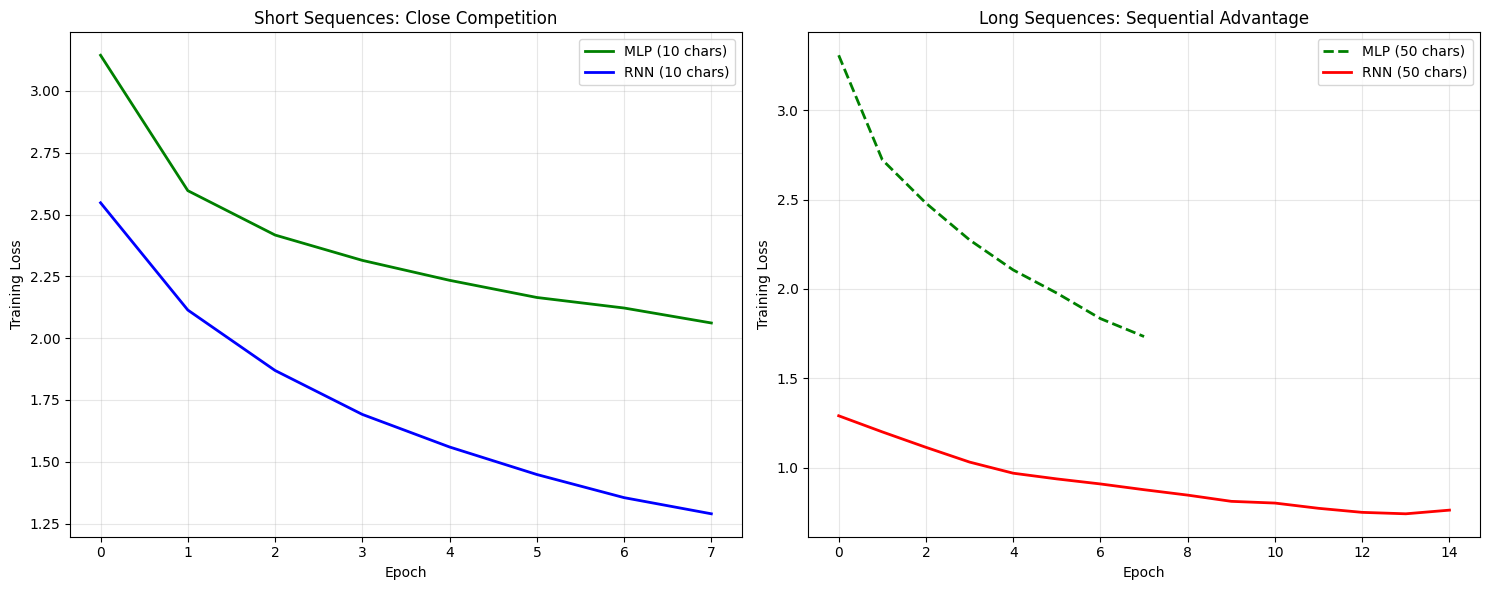


🔍 KEY INSIGHTS
• Short sequences: MLP can memorize local patterns
• Long sequences: RNN's sequential processing provides advantage
• Vanilla RNN still suffers from vanishing gradients on very long sequences
• This motivates the need for gated architectures (LSTM/GRU)


In [6]:
# Train models on LONG sequences to see sequential advantage
print("🚀 Training models on LONG sequences (50 characters)...")

# Create fresh models for long sequence training
rnn_long_model = models['rnn']
mlp_long_model = models['mlp_long']

print(f"\nTraining RNN (Extended: 15 epochs)...")
rnn_long_losses = train_model(rnn_long_model, long_X_train[:8000], long_y_train[:8000], epochs=15)

print(f"\nTraining MLP...")
mlp_long_losses = train_model(mlp_long_model, long_X_train[:8000], long_y_train[:8000], epochs=8, is_sequential=False)

# Evaluate on test set
print("\n" + "="*60)
print("📊 LONG SEQUENCE RESULTS (50 chars) - Test Set")
print("="*60)

mlp_long_test_loss, mlp_long_test_acc = evaluate_model(mlp_long_model, long_X_test[:2000], long_y_test[:2000], is_sequential=False)
rnn_long_test_loss, rnn_long_test_acc = evaluate_model(rnn_long_model, long_X_test[:2000], long_y_test[:2000], is_sequential=True)

long_results = {
    'MLP (50 chars)': (mlp_long_test_loss, mlp_long_test_acc),
    'RNN (50 chars)': (rnn_long_test_loss, rnn_long_test_acc)
}

print_performance_summary(long_results)

# Visualize training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Short vs Long comparison
ax1.plot(mlp_losses, 'g-', label='MLP (10 chars)', linewidth=2)
ax1.plot(rnn_short_losses, 'b-', label='RNN (10 chars)', linewidth=2)
ax1.set_title('Short Sequences: Close Competition')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Long sequences - where RNNs excel
ax2.plot(mlp_long_losses, 'g--', label='MLP (50 chars)', linewidth=2)
ax2.plot(rnn_long_losses, 'r-', label='RNN (50 chars)', linewidth=2)
ax2.set_title('Long Sequences: Sequential Advantage')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("🔍 KEY INSIGHTS")
print("="*60)
print("• Short sequences: MLP can memorize local patterns")
print("• Long sequences: RNN's sequential processing provides advantage")
print("• Vanilla RNN still suffers from vanishing gradients on very long sequences")
print("• This motivates the need for gated architectures (LSTM/GRU)")

## LSTM and GRU: Gated Solutions

In [7]:
# Extract gated models (LSTM and GRU)
lstm_model = models['lstm']
gru_model = models['gru']

print("🧠 Gated architectures solve vanishing gradients:")
print(f"  • LSTM: 3 gates (forget, input, output) + cell state")
print(f"  • GRU: 2 gates (reset, update) - simpler than LSTM")
print(f"\nParameter comparison:")
print(f"  • LSTM: {count_parameters(lstm_model):,} parameters")
print(f"  • GRU:  {count_parameters(gru_model):,} parameters")
print(f"  • RNN:  {count_parameters(rnn_long_model):,} parameters")

🧠 Gated architectures solve vanishing gradients:
  • LSTM: 3 gates (forget, input, output) + cell state
  • GRU: 2 gates (reset, update) - simpler than LSTM

Parameter comparison:
  • LSTM: 359,581 parameters
  • GRU:  277,149 parameters
  • RNN:  112,285 parameters


## Training Gated Models
*Extended training to show gated architectures overcoming vanishing gradients*

In [8]:
# Train gated models on long sequences
print("🚀 Training GATED models (extended training)...")

print("\nTraining LSTM (12 epochs)...")
lstm_losses = train_model(lstm_model, long_X_train[:8000], long_y_train[:8000], epochs=12)

print("\nTraining GRU (12 epochs)...")
gru_losses = train_model(gru_model, long_X_train[:8000], long_y_train[:8000], epochs=12)

# Evaluate all models on test set
print("\n" + "="*60)
print("📊 FINAL COMPARISON: All Models on Long Sequences")
print("="*60)

lstm_test_loss, lstm_test_acc = evaluate_model(lstm_model, long_X_test[:2000], long_y_test[:2000], is_sequential=True)
gru_test_loss, gru_test_acc = evaluate_model(gru_model, long_X_test[:2000], long_y_test[:2000], is_sequential=True)

# Compile all results
final_results = {
    'MLP': (mlp_long_test_loss, mlp_long_test_acc),
    'Vanilla RNN': (rnn_long_test_loss, rnn_long_test_acc),
    'LSTM': (lstm_test_loss, lstm_test_acc),
    'GRU': (gru_test_loss, gru_test_acc)
}

print_performance_summary(final_results)

print(f"\n💡 Expected ranking: LSTM/GRU > Vanilla RNN > MLP")
print(f"   (Gated models should handle long sequences better)")

🚀 Training GATED models (extended training)...

Training LSTM (12 epochs)...
Epoch  2: Loss = 2.1966
Epoch  2: Loss = 2.1966
Epoch  4: Loss = 1.7282
Epoch  4: Loss = 1.7282
Epoch  6: Loss = 1.4061
Epoch  6: Loss = 1.4061
Epoch  8: Loss = 1.1547
Epoch  8: Loss = 1.1547
Epoch 10: Loss = 0.9470
Epoch 10: Loss = 0.9470
Epoch 12: Loss = 0.7915

Training GRU (12 epochs)...
Epoch 12: Loss = 0.7915

Training GRU (12 epochs)...
Epoch  2: Loss = 2.1089
Epoch  2: Loss = 2.1089
Epoch  4: Loss = 1.5218
Epoch  4: Loss = 1.5218
Epoch  6: Loss = 1.0755
Epoch  6: Loss = 1.0755
Epoch  8: Loss = 0.7971
Epoch  8: Loss = 0.7971
Epoch 10: Loss = 0.6326
Epoch 10: Loss = 0.6326
Epoch 12: Loss = 0.4953

📊 FINAL COMPARISON: All Models on Long Sequences
Epoch 12: Loss = 0.4953

📊 FINAL COMPARISON: All Models on Long Sequences

PERFORMANCE SUMMARY
MLP         : Loss = 2.8353, Accuracy = 0.276
Vanilla RNN : Loss = 3.3031, Accuracy = 0.367
LSTM        : Loss = 2.6904, Accuracy = 0.394
GRU         : Loss = 3.1662, A

## Visual Comparison & Text Generation
*See training progress and generated text quality across architectures*

/Users/sohbetdovranov/udacity/deep-learning/cd1822-seq-models-transformers/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


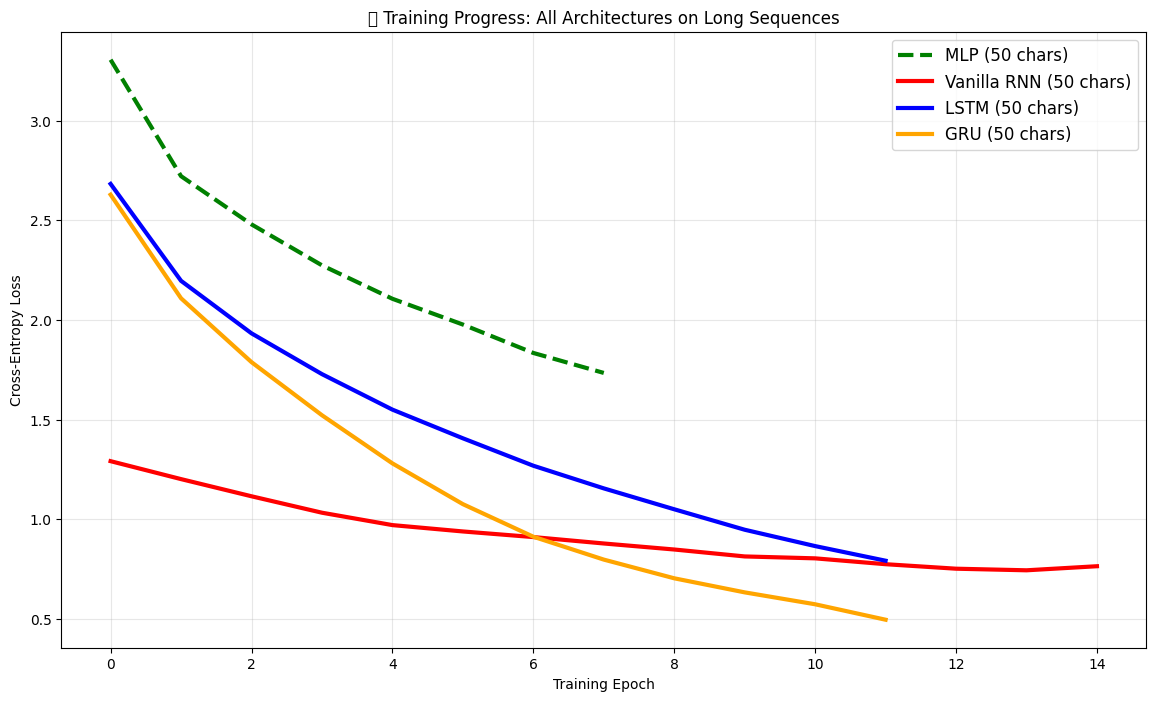

📈 Training Loss Rankings (final epoch):
1. GRU         : 0.4953
2. Vanilla RNN : 0.7638
3. LSTM        : 0.7915
4. MLP         : 1.7342

🎯 TEXT GENERATION COMPARISON
Seed: "The meaning of"

Vanilla RNN:
"The meaning offorta the impede addea the Nameless uan General that had accused of Gallian Gallia Co"

LSTM:
"The meaning of from Maximes , concentials at the Player . Regula <unk> the Players and acimat do no"

GRU:
"The meaning of lince prest , who had ack ouch becond <unk> Honjout the ca missions , the mojto he a"

💡 Notice: Gated models (LSTM/GRU) should produce more coherent text


In [9]:
# Visualize training curves for all models
plt.figure(figsize=(14, 8))
plt.plot(mlp_long_losses, 'g--', label='MLP (50 chars)', linewidth=3)
plt.plot(rnn_long_losses, 'r-', label='Vanilla RNN (50 chars)', linewidth=3)
plt.plot(lstm_losses, 'b-', label='LSTM (50 chars)', linewidth=3)
plt.plot(gru_losses, 'orange', linestyle='-', label='GRU (50 chars)', linewidth=3)
plt.xlabel('Training Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('🏁 Training Progress: All Architectures on Long Sequences')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("📈 Training Loss Rankings (final epoch):")
training_final = [
    ('LSTM', lstm_losses[-1]),
    ('GRU', gru_losses[-1]),
    ('Vanilla RNN', rnn_long_losses[-1]),
    ('MLP', mlp_long_losses[-1])
]
training_final.sort(key=lambda x: x[1])

for i, (model, loss) in enumerate(training_final, 1):
    print(f"{i}. {model:<12}: {loss:.4f}")

# Text generation comparison
print("\n" + "="*60)
print("🎯 TEXT GENERATION COMPARISON")
print("="*60)

seed_text = "The meaning of"
print(f'Seed: "{seed_text}"\n')

models_for_gen = [
    ('Vanilla RNN', rnn_long_model),
    ('LSTM', lstm_model), 
    ('GRU', gru_model)
]

for name, model in models_for_gen:
    sample = generate_sample(model, char2idx, idx2char, seed_text, max_length=85, vocab_size=vocab_size)
    print(f"{name}:")
    print(f'"{sample}"\n')

print("💡 Notice: Gated models (LSTM/GRU) should produce more coherent text")

In [ ]:
# Create comprehensive summary table
summary_data = {
    'Architecture': ['MLP', 'Vanilla RNN', 'LSTM', 'GRU'],
    'Test Loss': [f"{mlp_long_test_loss:.4f}", f"{rnn_long_test_loss:.4f}", f"{lstm_test_loss:.4f}", f"{gru_test_loss:.4f}"],
    'Test Accuracy': [f"{mlp_long_test_acc:.3f}", f"{rnn_long_test_acc:.3f}", f"{lstm_test_acc:.3f}", f"{gru_test_acc:.3f}"],
    'Parameters': [f"{count_parameters(models['mlp_long']):,}", f"{count_parameters(models['rnn']):,}", 
                   f"{count_parameters(models['lstm']):,}", f"{count_parameters(models['gru']):,}"],
    'Memory Mechanism': ['None (feedforward)', 'Hidden state', 'Cell + 3 gates', 'Hidden + 2 gates'],
    'Sequential Processing': ['❌', '✅', '✅', '✅'],
    'Handles Long Sequences': ['❌', '⚠️', '✅', '✅']
}

results_table = pd.DataFrame(summary_data)

print("\n" + "="*90)
print("🏆 FINAL ARCHITECTURE COMPARISON (50-Character Sequences)")
print("="*90)
print(results_table.to_string(index=False))

print("\n" + "="*90)
print("🎯 KEY TAKEAWAYS")
print("="*90)
print("1. 📱 Problem: Mobile keyboards need long-term context memory")
print("2. 🧠 MLP Solution: Fast but forgets - no sequential processing")
print("3. 🔄 RNN Solution: Sequential memory but suffers vanishing gradients")
print("4. 🚪 LSTM/GRU Solution: Gated architectures solve vanishing gradients")
print("5. ⚡ Performance: LSTM ≈ GRU > Vanilla RNN > MLP (on sequential tasks)")
print("6. 🎯 Best Choice: GRU often preferred (simpler, faster, similar performance)")

print("\n" + "="*90)

print(f"\n✅ Demo Complete! Sequential models provide clear advantages for memory-dependent tasks.")


🏆 FINAL ARCHITECTURE COMPARISON (50-Character Sequences)
Architecture Test Loss Test Accuracy Parameters   Memory Mechanism Sequential Processing Handles Long Sequences
         MLP    2.8353         0.276    111,485 None (feedforward)                     ❌                      ❌
 Vanilla RNN    3.3031         0.367    112,285       Hidden state                     ✅                     ⚠️
        LSTM    2.6904         0.394    359,581     Cell + 3 gates                     ✅                      ✅
         GRU    3.1662         0.378    277,149   Hidden + 2 gates                     ✅                      ✅

🎯 KEY TAKEAWAYS
1. 📱 Problem: Mobile keyboards need long-term context memory
2. 🧠 MLP Solution: Fast but forgets - no sequential processing
3. 🔄 RNN Solution: Sequential memory but suffers vanishing gradients
4. 🚪 LSTM/GRU Solution: Gated architectures solve vanishing gradients
5. ⚡ Performance: LSTM ≈ GRU > Vanilla RNN > MLP (on sequential tasks)
6. 🎯 Best Choice: GRU often pre